In [60]:
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from math import dist
from numpy import pi, sin, cos

IDEA: start with a matrix where each row is an image, and then replace each row with an average of its nearest neighbors (i.e. other rows within certain "distance", where "distance" is calculated between points in $\mathbb{R}^n$)

In [52]:
def denoise(M, radius):
    NewM = np.zeros((M.shape[0], M.shape[1]))
    for i in range(len(M)):
        neighbors = []
        for j in range(len(M)):
            if dist(M[i],M[j]) < radius:
                neighbors.append(M[j])
        NewM[i] = sum(neighbors)/len(neighbors)
    return NewM
        

In [54]:
def get_pixels(num_pixels, window_size):
    sample = list(np.linspace(-window_size/2, window_size/2, num_pixels))
    pixels = []
    for i in range(len(sample)):
        for j in range(len(sample)):
            pixels.append((sample[i],sample[j]))     
    return pixels


def get_colors(pixels, image_function):
    colors = []
    for pixel in pixels:
        colors.append(image_function(pixel[0],pixel[1]))
    return colors  

def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab

def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta

def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso

def generate_isom(n_isos, x_translate, y_translate):
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) # sampling from (-y,y)
    theta = list(2 * pi * np.random.random(n_isos)) # sampling from (0, 2pi)

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv

def new_colors(pixels, iso_inv, image_function):
    pixels_inv = []
    for pixel in pixels: 
        pixels_inv.append(iso_inv(pixel[0], pixel[1]))
    new_colors = get_colors(pixels_inv, image_function)
    return new_colors

def matrix_of_images(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([new_colors(pixels, i, image_function)])
    M = np.concatenate(vectors, axis=0 )
    return M

def p_hom(M, maxdim, coeff):
    output = ripser(M, maxdim = maxdim, coeff = coeff)
    return output
    
def persistent_H1_intervals(output):
    H1 = output['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    d
    return d

def plot_dgms(output):
    dgms = output['dgms']
    fig = plt.figure(figsize = (12, 6))
    plot_diagrams(dgms)
    
def pipeline(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

def graph(image_function, x, y, x_random = True, n_samples= 100000, y_random = True):
    
    if x_random == True:
        X = list(2 * x * np.random.random(n_samples) - x) 
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)      

    if x_random == False:
        X = np.linspace(-x,x,n_samples)
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)   

    points = []
    for i in range(n_samples):
        color = image_function(X[i],Y[i])
        if color == 1:
            points.append((X[i],Y[i])) 
        
    x_points = []
    y_points = []
    for i in points: 
        x_points.append(i[0])
        y_points.append(i[1])
        
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points)
    plt.show()
    
def view_window(image_function, num_pixels, window_size):
    
    pixels = get_pixels(num_pixels, window_size)

    points = []
    for pixel in pixels:
        color = image_function(pixel[0],pixel[1])
        if color == 1:
            points.append(pixel)
    
    x_points = []
    y_points = []
    for pixel in points:
        x_points.append(pixel[0])
        y_points.append(pixel[1])
    
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points)
    plt.show()
    
def matrix_pipeline(image_function, num_pixels, window_size, n_isos, x_translate, y_translate):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    return M

In [55]:
def sincos(x,y):
    return sin(2 * x + y) * cos(y)

In [57]:
def graph_continuous(image_function, x, y, x_random = True, n_samples= 100000, y_random = True):
    
    if x_random == True:
        X = list(2 * x * np.random.random(n_samples) - x) 
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)      

    if x_random == False:
        X = np.linspace(-x,x,n_samples)
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)   

    x_points = []
    y_points = []
    colors = []
    for i in range(n_samples):
        color = image_function(X[i],Y[i]) 
        colors.append(color)
        x_points.append(X[i])
        y_points.append(Y[i])

        
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points, c = colors)
    plt.show()
    
    
def view_window_continuous(image_function, num_pixels, window_size):
    
    pixels = get_pixels(num_pixels, window_size)
            
    x_points = []
    y_points = []
    colors = []
    for i in range(len(pixels)):
        color = image_function(pixels[i][0],pixels[i][1]) 
        colors.append(color)
        x_points.append(pixels[i][0])
        y_points.append(pixels[i][1])
    
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points, c = colors)
    plt.show()

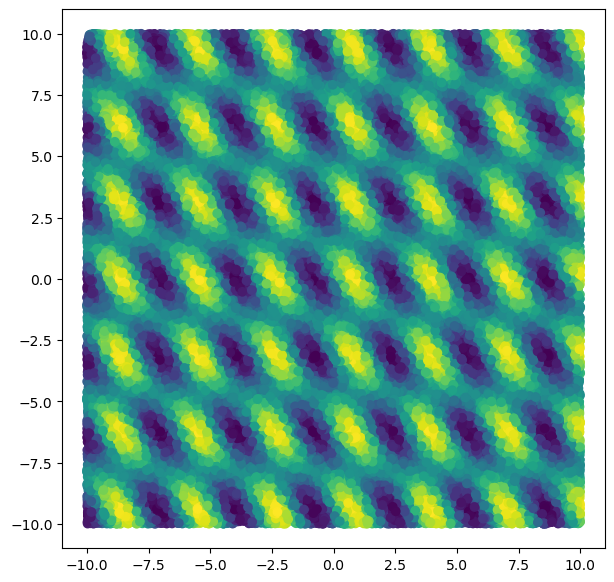

In [61]:
graph_continuous(sincos, 10, 10, x_random = True, n_samples= 100000, y_random = True)

In [70]:
M = matrix_pipeline(image_function = sincos, num_pixels = 30 , window_size = 4, n_isos = 2000, x_translate= 10 , y_translate=10)

In [71]:
M

array([[ 0.09705444,  0.19465086,  0.27366782, ...,  0.35535988,
         0.19573521,  0.0181632 ],
       [ 0.47908323,  0.19511396, -0.1091865 , ...,  0.34810268,
         0.55569713,  0.69912674],
       [-0.89284623, -0.86823936, -0.78197474, ..., -0.04901378,
        -0.04498171, -0.0373215 ],
       ...,
       [-0.20218197, -0.15614821, -0.11376705, ..., -0.92388046,
        -0.96108797, -0.98458652],
       [-0.25302813, -0.37881657, -0.50857269, ..., -0.59223505,
        -0.48006992, -0.35538363],
       [ 0.62164676,  0.70343216,  0.74727248, ..., -0.14472258,
         0.02048079,  0.19632213]])

In [77]:
NewM = denoise(M, 5)

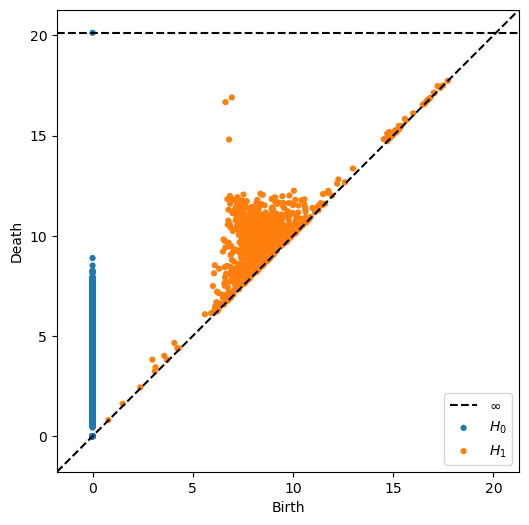

In [78]:
output = p_hom(NewM, maxdim=1, coeff=2)
plot_dgms(output)

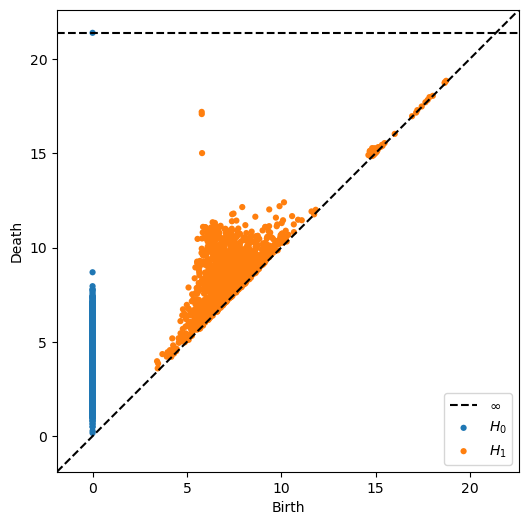

In [69]:
output = pipeline(image_function = sincos, num_pixels = 30 , window_size = 4, n_isos = 2000, x_translate= 10 , y_translate=10, maxdim=1, coeff=2)
plot_dgms(output)